# Assignment 2: Time Series Prediction of Sepsis

Author:

Alberto de los Ríos Salmerón


## Imports

- pandas: Provides data structures like DataFrames for efficient data manipulation and analysis, making it easy to clean, filter, and process structured data.


[pandas Dataframe documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)


- sklearn (scikit-learn): Offers machine learning tools for classification, regression, clustering, and preprocessing, including model selection and evaluation.


[scikit-learn documentation](https://scikit-learn.org/stable/api/index.html)


- numpy: Supports numerical computing with multi-dimensional arrays, mathematical functions, and efficient operations for handling large datasets.


[numpy documentation](https://numpy.org/doc/2.1/reference/#)


- matplotlib: Enables the creation of static, animated, and interactive visualizations, providing fine control over plots and charts.


[matplotlib documentation](https://matplotlib.org/stable/users/explain/quick_start.html)


- seaborn: Builds on Matplotlib to simplify statistical data visualization with attractive and informative default styles.


[seaborn documentation](https://seaborn.pydata.org/)


- imblearn (imbalanced-learn): Provides tools for handling imbalanced datasets, including oversampling, undersampling, and resampling techniques for machine learning.


[imblearn documentation](https://imbalanced-learn.org/stable/user_guide.html)


- joblib: Optimizes performance by enabling efficient parallel processing and caching for machine learning models and large data computations.


[joblin documentation](https://joblib.readthedocs.io/en/stable/)


- torch: imports the core PyTorch library for deep learning. It provides tensor operations and other high-level functionalities required to create and train neural networks.

1. torch.nn:  module in PyTorch that contains neural network layers, loss functions for creating your neural network models.
2. torch.optim: PyTorch library used for optimization. It provides optimization algorithms such as Adam, AdamW, and others that are used to update model parameters during training.

[torch documentation](https://pytorch.org/docs/stable/index.html)

In [1]:
import numpy as np
import pandas as pd
import joblib
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import imblearn
from imblearn.under_sampling import RandomUnderSampler

## Load data

This project has four different datasets A, B, C and D. We can find non-sepsis patients and patient that have suffer from it. Each row represents an lab observation at a specific timestep (each 30 mins) for a given patient.
Each lab report has a severity score assigned by clinial expert ranging from 0 to 1 for non-sepsis patient and form 2 to 4 to sepsis patients. 

[Load data](https://stackoverflow.com/questions/9652832/how-to-load-a-tsv-file-into-a-pandas-dataframe)

In [2]:
# Load the datasets
A = pd.read_csv('raw_data\sepsisexp_timeseries_partition-A.tsv', sep='\t', header=0)
B = pd.read_csv('raw_data\sepsisexp_timeseries_partition-B.tsv', sep='\t', header=0)
C = pd.read_csv('raw_data\sepsisexp_timeseries_partition-C.tsv', sep='\t', header=0)
D = pd.read_csv('raw_data\sepsisexp_timeseries_partition-D.tsv', sep='\t', header=0)

## PROJECT AIM: We want to create a neural network that predicts the sepsis onset for 2 hours, 4 hours and 6 hours in advance. 


## TASK 1: Data preprocesing

We have a number of patient that will eventually develop sepsis. This change is noticeable trough the severity score, the increase from 1 to 2 for any given patient means that the sepsis is triggered. 


We will focus just on patients that will eventually develop sepsis. We create another feature called 'onset_sepsis' where for each row, if the severity score is less than 2, we assign 0 and if it is 2 or greater we assign 1. By doing so, we can see at what point the sepsis triggers. 

We have to shift the values 2 hours, 4 hours and 6 hours to create the target variables and been able to predict them for every sepsis patient. 

We then transform the data in a tensor format that is acceptable by machine learning models, particularly neural networks. The X tensor gathers all samples, timesteps and number features. The y tensor is to multiple outputs, 3 one of each prediction. 


We have develop a undersampling method in case the target data was imbalaced but it not the case. Moreover, by deleting some rows we could modify the timesteps for any given patient. 


In [ ]:
# Preprocessing function
def data_cleaning(dataset, filename):
    #data = undersample_sepsis(data)
    data = dataset.copy()
    data = data[data['sepsis'] == 1]
    data = data.sort_values(by=['id', 'timestep'])

    data['onset_sepsis'] = (data['severity'] >= 2).astype(int)# Define onset of sepsis based on severity score

    data['onset_sepsis_2h'] = data.groupby('id')['onset_sepsis'].shift(-4) #shift 2 hours
    data['onset_sepsis_4h'] = data.groupby('id')['onset_sepsis'].shift(-8) #shift 4 hours
    data['onset_sepsis_6h'] = data.groupby('id')['onset_sepsis'].shift(-12) #shift 6 hours

    data['onset_sepsis_2h'] = data.groupby('id')['onset_sepsis_2h'].ffill()

    
    data['onset_sepsis_4h'] = data.groupby('id')['onset_sepsis_4h'].ffill() # Fill NaN values for onset_sepsis_4h
    data.loc[data['onset_sepsis_4h'].isna() & (data['onset_sepsis_2h'] == 1), 'onset_sepsis_4h'] = 1

    data['onset_sepsis_6h'] = data.groupby('id')['onset_sepsis_6h'].ffill() # Fill NaN values for onset_sepsis_6h
    data.loc[data['onset_sepsis_6h'].isna() & (data['onset_sepsis_4h'] == 1), 'onset_sepsis_6h'] = 1

    data = data.drop(columns=['sepsis', 'severity', 'onset_sepsis'])

    feature_names = data.drop(columns=['id', 'onset_sepsis_2h', 'onset_sepsis_4h', 'onset_sepsis_6h']).columns.tolist()

    X = data.drop(columns=['id', 'onset_sepsis_2h', 'onset_sepsis_4h', 'onset_sepsis_6h']).values
    y = data[['onset_sepsis_2h', 'onset_sepsis_4h', 'onset_sepsis_6h']].values  # Multi-label output

    X = X.reshape((X.shape[0], -1, X.shape[1]))
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    
    data.to_csv(f'processed_data/{filename}.csv', index=False)
    
    return X_tensor, y_tensor, feature_names
   

def undersample_sepsis(data):
    
    data_y = data['sepsis'] 
    data_X = data.drop('sepsis', axis=1)
 
    sampler = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = sampler.fit_resample(data_X, data_y) 

    data = pd.concat([X_resampled, y_resampled], axis=1)
    print(data['sepsis'].value_counts())
    
    return data




## TASK 2: LSTM DESIGN AND ARCHITECTURE

## Task 1: Implementation of Neural Network 

### LSTM

Long Short-Term Memory is a type of Recurrent Neural Network designed to handle long-term dependencies and sequences in data. Unlike traditional RNNs, LSTMs are capable of learning and retaining information over long periods.


Each LSTM has three primary components or gates that control the flow of information through the network:

1. Forget gate: Decides what information from the cell state should be discarded. The function employed is a sigmoid activation function that outputs values between 0 and 1, where 0 means "forget completely" and 1 means "keep all".

The cell state acts as a memory unit that retains information across time steps, and the hidden state carries the output to the next time step or layer.

2. Input gate: Determines what new information should be added to the cell state. It is made of two different parts, a sigmoid layer that determines which values will be updated, and a tanh layer that creates a vector of new candidate values to be added to the cell state.

3. Output gate: Determines the next hidden state based on the cell state and the output from the current time step. In this final step, a sigmoid function decides which parts of the cell state will contribute to the hidden state, and the cell state is passed through a tanh function before being multiplied by the output gate.

Moreover, the sequence of data enters the LSTM unit at each time step. At each time step, the forget, input, and output gates process the current input and previous hidden state to update the cell state and output.

### Advantages of LSTM
- Long-term memory: LSTMs can retain information for a long period due to the cell state.
- Learns temporal dependencies: Usefull for  tasks involving sequential data, where the current output depends on previous time steps, such as time series prediction.
- Control over information flow: control over what information should be remembered, updated, or forgotten.

### Architecture and Design

The model task is to process sequential data and predict multiple target variables at different time intervals. It uses three fully connected layers to predict the outcomes for the 2-hour, 4-hour, and 6-hour predictions based on the LSTM's hidden state at the final time step.

1. Input: the model takes an input features for each time step in the input sequence. 

2. LTSM layers: the core of the model is a 3 layer LSTM. We have a stacked architecture, where each layer's output is passed as input to the next layer. A dropout is applied between LSTM layers with a probability of 0.2, This means that, during training, 20% of the connections between the layers are randomly "dropped out" (set to zero) in each forward pass. This dropout occurs only between layers, not on the input or output layer.

3. Dropout layer after the LSTM: it is applied to the last hidden state output of the LSTM, after which the output is passed to the fully connected layers.

4. Three fully connected layer: these layers are used to make predictions for each of the three time intervals. The fully connected layers output a single value per prediction and apply a sigmoid activation to produce probabilities for binary classification task.

5. Forward pass: 
- Initialization of hidden states: the initial hidden state (h_0) and cell state (c_0) are initialized as zero tensors.
- LSTM Output: The x input is passed to the LSTM, which returns the hidden states (out) and cell states. the final hidden state is then processed by the dropout layer.
- Prediction: after applying dropout, the output is passed through the three fully connected layers. 

6. Output: the model returns three separate predictions for each target.

- [Pytorch Class LTSMModel](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
- [noplaxochia, 2024, LSTM from scratch](https://medium.com/@wangdk93/lstm-from-scratch-c8b4baf06a8b)
- [Saving and Loading Model con class LSTM](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
- [Long Short Term Memory (LSTM) Networks using PyTorch](https://www.geeksforgeeks.org/long-short-term-memory-networks-using-pytorch/)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2) #dropout=0.3 in between layers
        self.dropout = nn.Dropout(0.2)

        #self.fc = nn.Linear(hidden_size, 3) Single fully connected layer with 3 output neurons
        
        # Fully connected layers for each target (2h, 4h, 6h)
        self.fc_2_hours = nn.Linear(hidden_size, 1)  
        self.fc_4_hours = nn.Linear(hidden_size, 1)  
        self.fc_6_hours = nn.Linear(hidden_size, 1)  
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.dropout(out[:, -1, :])

        #out = self.fc(out)
        #out = self.sigmoid(out)
        #out_2_hours = out[:, 0]
        #out_4_hours = out[:, 1]
        #out_6_hours = out[:, 2]

        out_2_hours = self.sigmoid(self.fc_2_hours(out))
        out_4_hours = self.sigmoid(self.fc_4_hours(out))
        out_6_hours = self.sigmoid(self.fc_6_hours(out))
        
        return out_2_hours, out_4_hours, out_6_hours
    


## TASK 3: Results

In the next section we are going to explain every training, validation and testing step that we have followed. The most crucial part for developping a LSTM model is choosing correctly the hyperparameters tunning the algorithm, such as the number of layers, its hidden size, the batch size, the learning rate to name a few. We have followed a empirical method modifying each one of them until achieve satisfying results. 

Then, we will determine and visualise the variation of loss and validation loss acorss the epochs. Moreover, we will show the results of error score providing usefull insigths about the models performance on real and unseen data.  

### Kfold Validation

We will be training and testing the model 4 different times using all the datasets available. 

In order to keep the time dependencies between each row of the dataset we will concatenate each one of the four datasets that we have loaded, split them and fold them in a secuential manner. The resulting folds have not been shuffled, keeping the original timesteps. 

We concatenate three of the 4 datasets keeping one whole dataset for the testing process. We will have 4 different folds with a testing dataset with unseen information. 

- Fold 1: [B, C, D] [A] 
- Fold 2: [A, C, D] [B]
- Fold 3: [A, B, D] [C]
- Fold 4: [A, B, C] [D]

Then the split_data() method establishes the length of the trainig and validation datasets. For each fold, 80% of the concatenated data is used for the training and the remaining 20% for validation.   


In [ ]:
def split_data(data, train_ratio=0.8, val_ratio=0.2):
    total_size = len(data)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    
    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    
    return train_data, val_data

datasets = [A, B, C, D]
folds = []

for i in range(len(datasets)):
    train_val_data = pd.concat([datasets[j] for j in range(len(datasets)) if j != i], ignore_index=True)
    test_data = datasets[i]
    
    train_data, val_data = split_data(train_val_data)

    folds.append((train_data, val_data, test_data))


### Hyperparameters Definition 

First we need to understand each hyperparameter taken into account in the development of this LSTM model.

- Layers of LSTM: more layers allow models to learn more intricate patterns. Nevertheless, a model too complex may not generalize correctly the data and just memorizes the training dataset.

- Layer's hidden size: the number of units or neurones in the LSTM hidden layer. Increasing the number of neurones give the model more learning capacity. 

- Batch size: number of samples that will be fed into the model during training.

- Epochs: number of times the model will iterate over the entire training dataset.

- Patience: number of epochs to wait without improvement in validation loss before stopping training early. This parameters in quite useful in order not to waste time when the validation loss is not improving. We do not need to go through all the epochs when the results do not seem convinient. 

- Learning rate: It controls how much to change the model in response to the estimated error each time the model weights are updated.

- Weight decay: regularization technique that helps prevent overfitting by adding a penalty to the loss function for large weights.

### Testing and Validation of the LSTM Model

As we have priveously stated the model is trained for four different fold using the fold cross validation technique.

After preprocessing the datasets and transforming them into tensors we create the loader used to feed the model. At this point we establish the batch size we want to analyse each time. 

We set the LSTM model hyperparameters: 
- input size: 44 features
- number of layers : 3
- number of units per layer: 128

We create the loss function criterion as well as the optimizer and scheduler:
- BCE: measures the Binary Cross Entropy between the target and the input probabilities 
- Adaptaive Moment Estimator (Adam) Weight Decay. It adapts learning rates per parameter and includes momentum. Using this variation of the Adam optimizer, we can increase the weight decay to reduce overfitting.
- ReduceLROnPlateau: With this learning rate scheduler we can reduce learning rate when validation loss stops improving. In our case if the validation loss does not decrease in 7 epoch we reduce de learning rate by 70%.

Before starting the training and validating loop we have to set the number of epoch and the early stop mecanism. 

For each epoch, the model is set to train mode,  we feed the model the training tensors and determinde the loss score of each prediction then the backward() method computes gradients for backpropagation. The gradient clipping normalization prevents exploding gradients and finally the optimizer.step() method updates the model's weights. We finnaly store the loss score. Before the next epoch begins, the optimizer.zero_grad() method resets every gradients of all model parameters to zero before computing the next gradient update.

The model is set to evaluation mode disabling dropouts and batch normalisation. The method torch.no_grad() prevents gradient computation. We determine the validation loss for each prediction.  This step ensures we track model performance.

In order to prevent overfitting the have develop an early stop mecanism inwhich we stop the model's training when the validation loss stops improving for certain amount of epochs. In our case this number is setted by the patience = 30

We continue this process for 100 epochs or until the early stop mecanism triggers.

We save the model with the best validation loss results.

- [BCE loss Pytorch](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)
- [AdamW Optimizer](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html#torch.optim.AdamW)
- [ReduceLRonPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html)
- [Vrunda Bhattbhatt, 2024, A Step-by-Step Guide to Early Stopping in TensorFlow and PyTorch](https://medium.com/@vrunda.bhattbhatt/a-step-by-step-guide-to-early-stopping-in-tensorflow-and-pytorch-59c1e3d0e376)

### Error Score

Before testing the model we need to define which error score we are going to be analysing. I have chose the accuracy and te F1-score for this task. 

- Accuracy: It measures the percentage of correctly classified instances either true or false in the dataset out of the total classifies instances. 
- F1-score: It represents the harmonic mean of precision and recall. The first one, measures how many of the predicted positives are actually correct. The recall metric measures how many actual positives were correctly identified.

Throughout the testing step we determine the accuracy and f1-score of the three predictions per fold. Then we calculate the mean of each score out of the results of all four folds. By doing so, we ensure that we are evaluating the model's true generalization ability, not just its luck on one particular fold.
Each fold uses a different subset of the data for training and validation. Some folds may perform better or worse due to the randomness in data splitting.

### Testing of the LSTM Model

In other to evaluate the model, first we load the model saved with the best hyperparameters. We set the evalution mode and discourage the gradient computation. We then feed the model with the testing data tensor in order to obtain 3 different prediction one for each timeframe.

Furthermore, we calculate each evalution metric comparing the results from the predicted values and the actual real ones. We then save the best model with the highest accuracy score throughout the four folds.



### Hyperparameter tunning

The real challenge of this project was setting hyperparameters values that allow us having coherent results. 

The biggest problem has been dealing with overfitting from the very start of the task. I started the first evalutions with a low batch size (32) and quite high hidden layer size (64) and high learning rate 0.01. The loss decreased but the validation loss was always increasing. The model learnt the training data too well, became too complex and did not performed well on unseen data.

We have been modifying the model one parameter at a time to notice the improvements. First, we selected a bigger batch and a model with fewer layers and units. The objective was to obtain and underfitted model and then, be able to increase its complexity little by little. This was achieve by increasing the number of layer and neurones progressively as well as decreasing the learning rate. 

The final tunning hyperparameters were:

- number of layer: 3
- number of neurones: 128
- batch size: 512
- epochs: 100
- learning rate: 1e-5
- weight decay: 1e-4
- patience: 30




LSTMModel(
  (lstm): LSTM(44, 128, num_layers=3, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc_2_hours): Linear(in_features=128, out_features=1, bias=True)
  (fc_4_hours): Linear(in_features=128, out_features=1, bias=True)
  (fc_6_hours): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Fold 1, Epoch [1/100], Loss: 2.0759, Val Loss: 2.0810
Fold 1, Epoch [2/100], Loss: 2.0740, Val Loss: 2.0680
Fold 1, Epoch [3/100], Loss: 2.0319, Val Loss: 2.0140
Fold 1, Epoch [4/100], Loss: 1.9834, Val Loss: 1.8906
Fold 1, Epoch [5/100], Loss: 1.6516, Val Loss: 1.8118
Fold 1, Epoch [6/100], Loss: 1.5869, Val Loss: 1.7755
Fold 1, Epoch [7/100], Loss: 1.6412, Val Loss: 1.7565
Fold 1, Epoch [8/100], Loss: 1.8145, Val Loss: 1.7406
Fold 1, Epoch [9/100], Loss: 1.7706, Val Loss: 1.7274
Fold 1, Epoch [10/100], Loss: 1.5723, Val Loss: 1.7133
Fold 1, Epoch [11/100], Loss: 1.7213, Val Loss: 1.7068
Fold 1, Epoch [12/100], Loss: 1.4356, Val Loss: 1.7

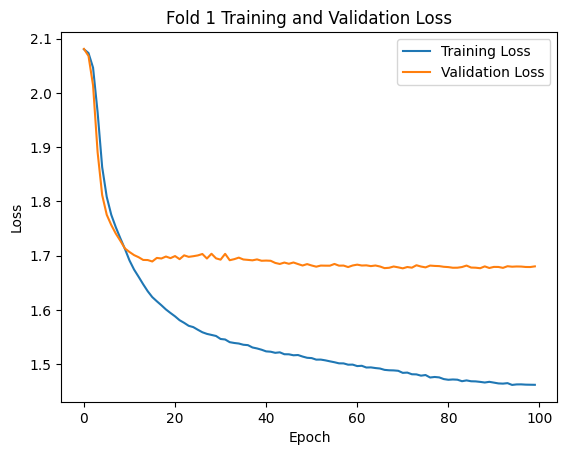



LSTMModel(
  (lstm): LSTM(44, 128, num_layers=3, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc_2_hours): Linear(in_features=128, out_features=1, bias=True)
  (fc_4_hours): Linear(in_features=128, out_features=1, bias=True)
  (fc_6_hours): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Fold 2, Epoch [1/100], Loss: 2.0717, Val Loss: 2.0872
Fold 2, Epoch [2/100], Loss: 2.0579, Val Loss: 2.0771
Fold 2, Epoch [3/100], Loss: 1.9878, Val Loss: 2.0286
Fold 2, Epoch [4/100], Loss: 1.9523, Val Loss: 1.9516
Fold 2, Epoch [5/100], Loss: 1.9009, Val Loss: 1.8870
Fold 2, Epoch [6/100], Loss: 1.8385, Val Loss: 1.8308
Fold 2, Epoch [7/100], Loss: 1.7001, Val Loss: 1.7816
Fold 2, Epoch [8/100], Loss: 1.6277, Val Loss: 1.7456
Fold 2, Epoch [9/100], Loss: 1.6109, Val Loss: 1.7161
Fold 2, Epoch [10/100], Loss: 1.6352, Val Loss: 1.6911
Fold 2, Epoch [11/100], Loss: 1.7371, Val Loss: 1.6728
Fold 2, Epoch [12/100], Loss: 1.5688, Val Loss: 1.6

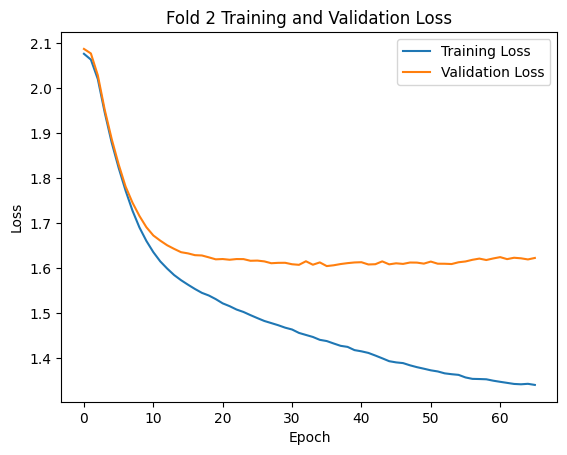



LSTMModel(
  (lstm): LSTM(44, 128, num_layers=3, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc_2_hours): Linear(in_features=128, out_features=1, bias=True)
  (fc_4_hours): Linear(in_features=128, out_features=1, bias=True)
  (fc_6_hours): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Fold 3, Epoch [1/100], Loss: 2.0715, Val Loss: 2.0864
Fold 3, Epoch [2/100], Loss: 2.0624, Val Loss: 2.0740
Fold 3, Epoch [3/100], Loss: 2.0022, Val Loss: 2.0159
Fold 3, Epoch [4/100], Loss: 1.8668, Val Loss: 1.8892
Fold 3, Epoch [5/100], Loss: 1.8863, Val Loss: 1.8102
Fold 3, Epoch [6/100], Loss: 1.7248, Val Loss: 1.7661
Fold 3, Epoch [7/100], Loss: 1.7409, Val Loss: 1.7367
Fold 3, Epoch [8/100], Loss: 1.6531, Val Loss: 1.7129
Fold 3, Epoch [9/100], Loss: 1.6225, Val Loss: 1.6959
Fold 3, Epoch [10/100], Loss: 1.5899, Val Loss: 1.6794
Fold 3, Epoch [11/100], Loss: 1.7140, Val Loss: 1.6708
Fold 3, Epoch [12/100], Loss: 1.6138, Val Loss: 1.6

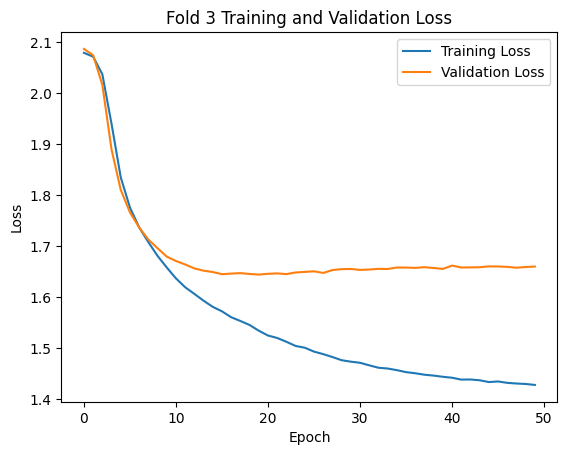



LSTMModel(
  (lstm): LSTM(44, 128, num_layers=3, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc_2_hours): Linear(in_features=128, out_features=1, bias=True)
  (fc_4_hours): Linear(in_features=128, out_features=1, bias=True)
  (fc_6_hours): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Fold 4, Epoch [1/100], Loss: 2.0749, Val Loss: 2.0756
Fold 4, Epoch [2/100], Loss: 2.0471, Val Loss: 2.0592
Fold 4, Epoch [3/100], Loss: 1.9650, Val Loss: 2.0045
Fold 4, Epoch [4/100], Loss: 1.8109, Val Loss: 1.9147
Fold 4, Epoch [5/100], Loss: 1.8030, Val Loss: 1.8483
Fold 4, Epoch [6/100], Loss: 1.6292, Val Loss: 1.7995
Fold 4, Epoch [7/100], Loss: 1.6565, Val Loss: 1.7665
Fold 4, Epoch [8/100], Loss: 1.5375, Val Loss: 1.7380
Fold 4, Epoch [9/100], Loss: 1.6011, Val Loss: 1.7151
Fold 4, Epoch [10/100], Loss: 1.4632, Val Loss: 1.6974
Fold 4, Epoch [11/100], Loss: 1.7079, Val Loss: 1.6815
Fold 4, Epoch [12/100], Loss: 1.4563, Val Loss: 1.6

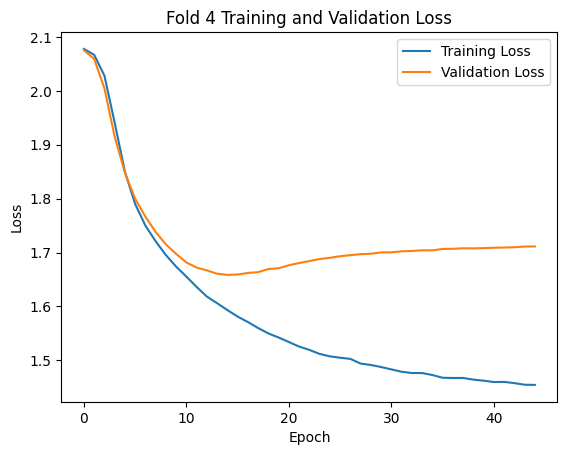


Overall: Accuracy for 2 Hours Target: 0.7058075439817235 F1 Score: 0.6955089417804708
Overall: Accuracy for 4 Hours Target: 0.7054411455756261 F1 Score: 0.6964164882588684
Overall Accuracy for 6 Hours Target: 0.7048907356099723 F1 Score: 0.6969673852939644


In [ ]:
def train_and_validate(folds):
    best_overall_accuracy = 0
    best_overall_model = None
    best_fold_idx = -1
    best_val_data = None

    accuracy_2_hours_list = []
    accuracy_4_hours_list = []
    accuracy_6_hours_list = []

    F1_score_2_hours_list = []
    F1_score_4_hours_list = []
    F1_score_6_hours_list = []
       
    for fold_idx, (train_data, val_data, test_data) in enumerate(folds):

        X_train_tensor, y_train_tensor, feature_names = data_cleaning(train_data, 'Training')
        X_val_tensor, y_val_tensor, feature_names = data_cleaning(val_data, 'Validation')
        X_test_tensor, y_test_tensor, feature_names = data_cleaning(test_data, 'Testing')
           
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
    
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
        
        input_size = X_train_tensor.shape[2] 
        hidden_size = 128 
        num_layers = 3 

        model = LSTMModel(input_size, hidden_size, num_layers)
        print('\n')
        print(model)
        print('\n')
        
        criterion = nn.BCELoss()
        optimizer = optim.AdamW(model.parameters(), lr=0.00001, weight_decay=1e-4) 
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.7) # A JUSTIFICAR

        
        best_val_loss = float('inf')
        best_model = None
        patience = 30 
        trigger_times = 0
        
        num_epochs = 100
        training_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                outputs_2_hours, outputs_4_hours, outputs_6_hours = model(X_batch)
                               
                loss_2_hours = criterion(outputs_2_hours.squeeze(), y_batch[:, 0])  # Calculate loss for 2 hours
                loss_4_hours = criterion(outputs_4_hours.squeeze(), y_batch[:, 1])  # Calculate loss for 4 hours
                loss_6_hours = criterion(outputs_6_hours.squeeze(), y_batch[:, 2])  # Calculate loss for 6 hours
                loss = loss_2_hours + loss_4_hours + loss_6_hours
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                epoch_loss += loss.item()

            epoch_loss /= len(train_loader)
            training_losses.append(epoch_loss)    
            
            model.eval()
            val_loss_2_hours = 0
            val_loss_4_hours = 0
            val_loss_6_hours = 0
            with torch.no_grad():
                for X_val_batch, y_val_batch in val_loader:
                    val_outputs_2_hours, val_outputs_4_hours, val_outputs_6_hours = model(X_val_batch)
                    val_loss_2_hours += criterion(val_outputs_2_hours.squeeze(), y_val_batch[:, 0]).item()
                    val_loss_4_hours += criterion(val_outputs_4_hours.squeeze(), y_val_batch[:, 1]).item()
                    val_loss_6_hours += criterion(val_outputs_6_hours.squeeze(), y_val_batch[:, 2]).item()
            val_loss_2_hours /= len(val_loader)
            val_loss_4_hours /= len(val_loader)
            val_loss_6_hours /= len(val_loader)
            val_loss = val_loss_2_hours + val_loss_4_hours + val_loss_6_hours
            val_losses.append(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model.state_dict()
                trigger_times = 0
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print('\n')
                    print(f'Early stopping at epoch {epoch+1}')
                    break
            
            print(f'Fold {fold_idx+1}, Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')
            scheduler.step(val_loss)
        
        model.load_state_dict(best_model) 
        
        model.eval()
        with torch.no_grad(): 
            y_pred_2_hours, y_pred_4_hours, y_pred_6_hours = model(X_test_tensor)
            y_pred_2_hours = y_pred_2_hours.squeeze().round()
            y_pred_4_hours = y_pred_4_hours.squeeze().round()
            y_pred_6_hours = y_pred_6_hours.squeeze().round()

            accuracy_2_hours = accuracy_score(y_test_tensor[:, 0], y_pred_2_hours)
            f1_2_hours = f1_score(y_test_tensor[:, 0], y_pred_2_hours)
            accuracy_4_hours = accuracy_score(y_test_tensor[:, 1], y_pred_4_hours)
            f1_4_hours = f1_score(y_test_tensor[:, 1], y_pred_4_hours)
            accuracy_6_hours = accuracy_score(y_test_tensor[:, 2], y_pred_6_hours)
            f1_6_hours = f1_score(y_test_tensor[:, 2], y_pred_6_hours)
            overall_accuracy = (accuracy_2_hours + accuracy_4_hours + accuracy_6_hours) / 3
            
            print('\n')
            print(f'Fold {fold_idx+1} Results:')
            print(f'2 hours prediction:')
            print(f'Accuracy: {accuracy_2_hours:.4f}, F1 Score: {f1_2_hours:.4f}')
            print(f'4 hours prediction:')
            print(f'Accuracy: {accuracy_4_hours:.4f}, F1 Score: {f1_4_hours:.4f}')
            print(f'6 hours prediction:')
            print(f'Accuracy: {accuracy_6_hours:.4f}, F1 Score: {f1_6_hours:.4f}')
              
            accuracy_2_hours_list.append(accuracy_2_hours)
            accuracy_4_hours_list.append(accuracy_4_hours)
            accuracy_6_hours_list.append(accuracy_6_hours)

            F1_score_2_hours_list.append(f1_2_hours)
            F1_score_4_hours_list.append(f1_4_hours)    
            F1_score_6_hours_list.append(f1_6_hours)
            

            if overall_accuracy > best_overall_accuracy:
                        best_overall_accuracy = overall_accuracy
                        best_overall_model = best_model
                        best_fold_idx = fold_idx
                        best_val_data = (X_val_tensor, y_val_tensor)

            evaluation_data = [
                ['2 Hours', accuracy_2_hours, f1_2_hours],
                ['4 Hours', accuracy_4_hours, f1_4_hours],
                ['6 Hours', accuracy_6_hours, f1_6_hours]]
            
            evaluation_df = pd.DataFrame(evaluation_data, columns=['Target Class', 'Accuracy', 'F1 Score'])
            evaluation_df.to_csv(f'results/evaluation_fold_{fold_idx+1}_128h_3layer.csv', index=False)

        # Plots
        plt.figure()
        plt.plot(training_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Fold {fold_idx+1} Training and Validation Loss')
        plt.legend()
        plt.savefig(f'results/loss_plot_fold_{fold_idx+1}.png')
        plt.show()

    overall_accuracy_2_hours = np.mean(accuracy_2_hours_list)
    overall_accuracy_4_hours = np.mean(accuracy_4_hours_list)
    overall_accuracy_6_hours = np.mean(accuracy_6_hours_list)

    overall_f1_2_hours = np.mean(F1_score_2_hours_list)
    overall_f1_4_hours = np.mean(F1_score_4_hours_list)
    overall_f1_6_hours = np.mean(F1_score_6_hours_list)

    print('\nOverall: Accuracy for 2 Hours Target:', overall_accuracy_2_hours, 'F1 Score:', overall_f1_2_hours)
    print('Overall: Accuracy for 4 Hours Target:', overall_accuracy_4_hours, 'F1 Score:', overall_f1_4_hours)
    print('Overall Accuracy for 6 Hours Target:', overall_accuracy_6_hours, 'F1 Score:', overall_f1_6_hours)

    joblib.dump(best_overall_model, 'models/best_model.pkl')

    return best_fold_idx, best_val_data, best_overall_model, feature_names
    
    
best_fold_idx, best_val_data, best_overall_model, feature_names = train_and_validate(folds)







### Gradient-Based Feature Importance of the LSTM Model

After researching about feature importance for LSTM model, we have encounter an interesting article about several techniques for Deep Learning models that could be applyied in this case: 

"Feature Elimination: One common method involves removing specific features and observing the impact on model performance. Research indicates that eliminating the Speed parameter leads to a significant decline in prediction accuracy. This method, while effective, can disrupt the learned interactions between features in deeper network layers.

Permutation Importance: This technique involves randomly permuting feature values while keeping relevant neurons active. It allows for the exploration of relationships between the target feature and other input features. For example, studies have demonstrated how different features influence predictions in Multi-layer Perceptrons, particularly in pedestrian crossing intentions.

Gradient-based Techniques: For deep neural networks (DNNs), gradient-based class activation maps (CAM) compute the gradient of the output concerning input features. High gradient values indicate features that significantly impact predictions, although these methods are typically suited for simpler tasks like image classification"

We tried to implement a permutation importance method. But, since it determines the influence of every feature one at the time and analyses their impact on the model, the computing time was excessive. 

We have developed a gradient based feauture importance technique loading the best model available in our models folder.

First, the model is set to the evaluation mode with the gradient tracking function enabled. For this technique we will focus just on the validation data. We track the gradient values for each one of the three predictions. We then determine the loss using the BCE function between the model's output for that prediction target and the validation data value. Moreover, we compute the gradient using the backpropagration and we extrait the gradients feature importance. Lastly, we take the absolute value of the gradient to determine the magnitude of influence and average across all the timesteps. 

This technique is quite useful to measure the sensitivity of each feature over the models outcome. If a feature has a high gradient, small changes in that feature cause significant changes in the model’s predictions.

We have been struggling with memory allocation problems and wanted to understand the the a amount of memory usage devoted to each task. We ran the entire script on CPU because the computer lacks a GPU.

- [Advanced Techniques for Feature Importance in Deep Learning Models](https://www.restack.io/p/automated-feature-selection-techniques-answer-neural-network-feature-importance-pytorch-cat-ai#cm3il82rridokehpnv4ysqrvu)


CUDA is not available. Running on CPU.
Model is on: cpu
X_val_tensor is on: cpu
Before forward pass Memory Usage: 5341.88 MB (Total: 6387.63 MB)
X_val_tensor shape: torch.Size([80701, 1, 44])
X_val_tensor size: 14203376 bytes
After forward pass Memory Usage: 5901.72 MB (Total: 6387.63 MB)
After loss computation Memory Usage: 5907.30 MB (Total: 6387.63 MB)
After backward pass Memory Usage: 5033.60 MB (Total: 6387.63 MB)
After computing gradients Memory Usage: 5042.48 MB (Total: 6387.63 MB)
After deleting local variables Memory Usage: 5041.35 MB (Total: 6387.63 MB)


<Figure size 1500x700 with 0 Axes>

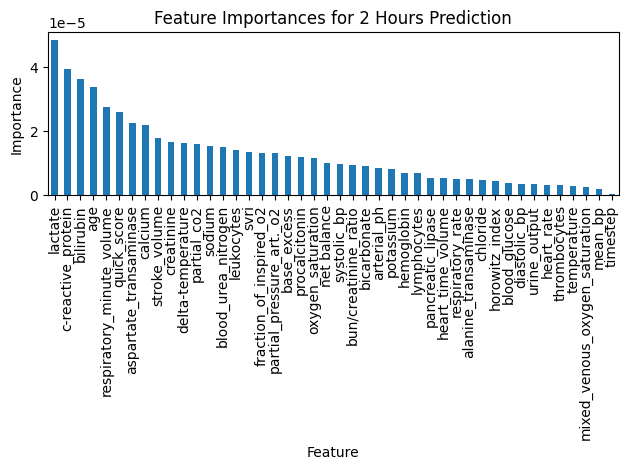

Before forward pass Memory Usage: 5424.46 MB (Total: 6387.63 MB)
X_val_tensor shape: torch.Size([80701, 1, 44])
X_val_tensor size: 14203376 bytes
After forward pass Memory Usage: 6085.15 MB (Total: 6387.63 MB)
After loss computation Memory Usage: 6078.94 MB (Total: 6387.63 MB)
After backward pass Memory Usage: 5243.94 MB (Total: 6387.63 MB)
After computing gradients Memory Usage: 4657.32 MB (Total: 6387.63 MB)
After deleting local variables Memory Usage: 4658.61 MB (Total: 6387.63 MB)


<Figure size 1500x700 with 0 Axes>

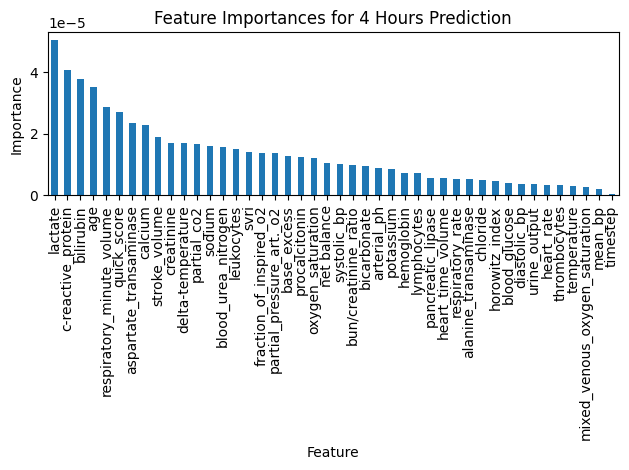

Before forward pass Memory Usage: 4716.74 MB (Total: 6387.63 MB)
X_val_tensor shape: torch.Size([80701, 1, 44])
X_val_tensor size: 14203376 bytes
After forward pass Memory Usage: 6106.10 MB (Total: 6387.63 MB)
After loss computation Memory Usage: 6102.75 MB (Total: 6387.63 MB)
After backward pass Memory Usage: 4698.71 MB (Total: 6387.63 MB)
After computing gradients Memory Usage: 4696.84 MB (Total: 6387.63 MB)
After deleting local variables Memory Usage: 4696.47 MB (Total: 6387.63 MB)


<Figure size 1500x700 with 0 Axes>

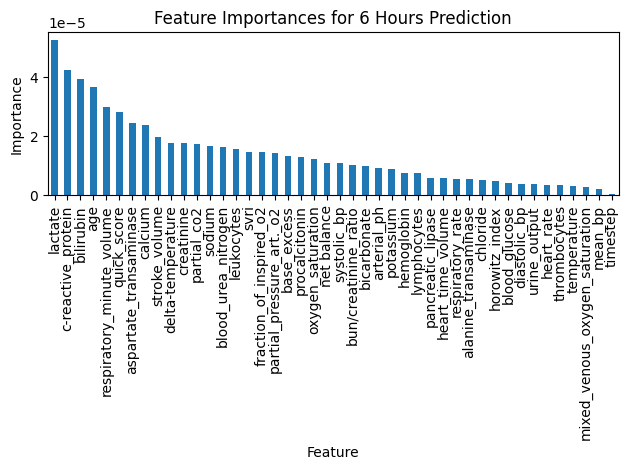

In [ ]:
import psutil
del A, B, C, D, datasets, folds, test_data, train_data, train_val_data  # Free memory

if torch.cuda.is_available():
    print(f"CUDA is available! Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Running on CPU.")


def print_memory_usage(tag=""):
    memory = psutil.virtual_memory()
    print(f"{tag} Memory Usage: {memory.used / 1e6:.2f} MB (Total: {memory.total / 1e6:.2f} MB)")

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model_path = 'models/best_model.pkl' 
state_dict = joblib.load(model_path) #Load model

model = LSTMModel(input_size=44, hidden_size=128, num_layers=3) 
model.load_state_dict(state_dict)
model.to(device)
model.eval()

criterion = nn.BCELoss()

X_val_tensor, y_val_tensor = best_val_data #Load validation data
X_val_tensor, y_val_tensor = X_val_tensor.to(device), y_val_tensor.to(device)

print(f"Model is on: {next(model.parameters()).device}")
print(f"X_val_tensor is on: {X_val_tensor.device}") 


def gradient_feature_importance(model, X_val, y_val, target):

    model.eval()
    X_val.requires_grad = True

    print_memory_usage("Before forward pass")

    print(f"X_val_tensor shape: {X_val.shape}") 
    print(f"X_val_tensor size: {X_val.numel() * X_val.element_size()} bytes")

    criterion = nn.BCELoss()
    
    if target == '2_hours':
        outputs = model(X_val)[0]
        y_val_target = y_val[:, 0]
    elif target == '4_hours':
        outputs = model(X_val)[1]
        y_val_target = y_val[:, 1]
    elif target == '6_hours':
        outputs = model(X_val)[2]
        y_val_target = y_val[:, 2]
    print_memory_usage("After forward pass")

    loss = criterion(outputs.squeeze(), y_val_target) 
    print_memory_usage("After loss computation")

    loss.backward()
    print_memory_usage("After backward pass")

    gradients = X_val.grad.abs().mean(dim=1).mean(dim=0).cpu().numpy()
    print_memory_usage("After computing gradients")

    del loss, outputs, y_val_target
    print_memory_usage("After deleting local variables")

    return gradients
    

feature_importances_2_hours = gradient_feature_importance(model, X_val_tensor, y_val_tensor, '2_hours')

feature_importance_df_2_hours = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_2_hours
}).sort_values(by='Importance', ascending=False)
feature_importance_df_2_hours.to_csv('results/feature_importances_2_hours.csv', index=False)

# Plots
plt.figure(figsize=(15, 7))
feature_importance_df_2_hours.plot(kind='bar', x='Feature', legend=False)
plt.title('Feature Importances for 2 Hours Prediction')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.savefig('results/feature_importances_2_hours.png')
plt.show()

feature_importances_4_hours = gradient_feature_importance(model, X_val_tensor, y_val_tensor, '4_hours')

feature_importance_df_4_hours = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_4_hours
}).sort_values(by='Importance', ascending=False)
feature_importance_df_4_hours.to_csv('results/feature_importances_4_hours.csv', index=False)


plt.figure(figsize=(15, 7))
feature_importance_df_4_hours.plot(kind='bar', x='Feature', legend=False)
plt.title('Feature Importances for 4 Hours Prediction')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.savefig('results/feature_importances_4_hours.png')
plt.show()

feature_importances_6_hours = gradient_feature_importance(model, X_val_tensor, y_val_tensor, '6_hours')

feature_importance_df_6_hours = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_6_hours
}).sort_values(by='Importance', ascending=False)
feature_importance_df_6_hours.to_csv('results/feature_importances_6_hours.csv', index=False)


plt.figure(figsize=(15, 7))
feature_importance_df_6_hours.plot(kind='bar', x='Feature', legend=False)
plt.title('Feature Importances for 6 Hours Prediction')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.savefig('results/feature_importances_6_hours.png')
plt.show()

## Discussion

In this study, we developed a Long Short-Term Memory model to predict the onset of sepsis at different time intervals (2 hours, 4 hours, and 6 hours in advance). The model consists of three LSTM layers with 128 neurons a dropout rate of 0.2 applied between layers and after the output layer, and three fully connected layer with one units each. The training was done in four folds over a batch size of 512 samples, a learning rate of 1e-5, weight decay of 1e-4. The goal was to assess the model's performance, analyze the error scores, and evaluate its advantages and limitations for prediction tasks.

### Model architecture and hyperparameters
The LSTM model was selected due to its strength in handling sequential data, particularly time-series data like those used in predicting sepsis onset. The three-layer LSTM structure, combined with 128 neurons per layer, provides a balance between model complexity and capacity for learning temporal dependencies. The choice of dropout at 0.2 helps prevent overfitting by introducing regularization.
The use of the sigmoid activation function for the output layer is appropriate, as it maps the model’s predictions to a probability between 0 and 1, aligning with the binary classification nature of the task, sepsis onset or no sepsis.

### Training results 
The model was trained over multiple folds, with the loss consistently decreasing across epochs, as evidenced by the loss and validation loss values during training. However, the validation loss did not consistently decrease in tandem with the training loss, indicating some potential overfitting or issues with generalization.

The observed fluctuations in the validation loss, with slight increases at certain points, suggest that the model might struggle with some aspects of the data, potentially due to noise. These fluctuations are typical in complex models like LSTMs and may reflect the model’s difficulty in generalizing to unseen data.

### Error score and Gradient-based feature importance
The model’s performance can be assessed using appropriate evaluation metrics like accuracy and F1-Score. 
We have determined, for each fold, the evaluation metrics of each prediction. Moreover, we have averaged the results for each predicted target. Cross-validation use different training and testing sets, so the model may perform slightly differently depending on the data. Averaging the scores from each fold helps smooth out fluctuations and gives a more reliable estimate of performance. It can also help to mitigate bias, a model may perform unusually well or poorly on a particular fold due to the way the data is distributed. By averaging across multiple folds, we reduce the impact of such biases.

The highest overall accuracy was obtained for the two hours in advance sepsis prediction target with a score of 70,58% and a F1-score of 69,55%. The worst results are those of the 6 hours in advance prediction with scores of 70,49% and F1-score of 69,70%. We can see that the model predicts in a better way events in the near future. Nevertheless, this results are quite close. We can espect similar outcomes.

As for the feature importance, we have see that for every prediction target, we have the same top 5 most influencial features.  In this case, the gradient values of the features "lactate","c-reactive_protein", "bilirubin", "age" and the "respiratory_minute_volume" significantly impact the model's predictions.

### Limitations
We have encountered several limitations during this project. 
1. Overfitting: Despite the dropout, the model still experiences fluctuations in validation loss, suggesting that it may be overfitting to the training data. This could be due to an insufficient amount of training data or overly complex model architecture for the dataset.
2. Computational Cost: These LSTM models, especially with multiple layers and large batch sizes, are computationally expensive. This might be a limitation in real-time clinical applications, where prediction speed and resource constraints are critical.    